<a href="https://colab.research.google.com/github/RogerUltimate/-Keras-study/blob/main/8_4_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 8-4 Code 실습(변이형 오토인코더)

## 오토인코더(Auto Encoder)
### 인코딩(encoding)과 디코딩(decoding)
- 인코딩-디코딩 아키텍쳐는 통신, 암호, 전자 등 다양한 분야에 적용되는 일반적인 프레임워크
- 인코더는 입력 샘플을 **잠재 공간**(저차원 벡터공간), 즉 인코더에 의해 정의된 숨겨진 구조화된 값 집합에 매핑하는 함수
- 디코더는 이 잠재 공간의 요소를 사전 정의된 타켓 도메인으로 매핑하는 여함수
- 예를 들어, 이미지와 오디오 압축 포맷
 - JPEG 도구는 미디어 파일을 가벼운 이진파일로 압축하여 인코딩하고, 표시할 때 픽셀값을 복원하기 위해 디코딩
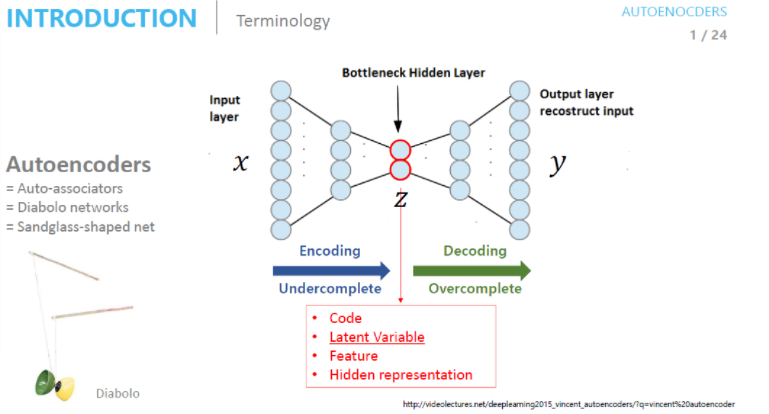

## 변이형 오토인코더(Variational AutoEncoders, VAE)
- 입력 이미지를 잠재 공간의 고정된 코딩으로 압축하는 대신 
이미지를 어떤 통계 분포의 파라미터로 변환
- 평균과 분산 파라미터를 사용하여 이 분포에서 무작위로 하나의 샘플을 추출
- 해당 샘플을 디코딩하여 원본 입력으로 복원
- 위 과정은 안정성을 향상, 잠재 공간 어디에서든 의미있는 표현을 인코딩하게 함
- 이미지 생성을 위한 강력한 도구

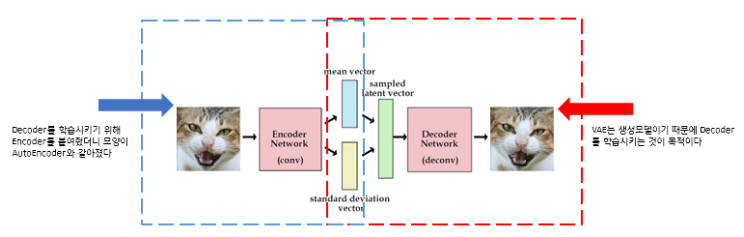


### VAE의 훈련
- 디코딩된 샘플이 원본 입력과 동일하도록 만드는 재구성 손실(reconstruction loss)
- 잠재 공간을 잘 형성하고 훈련 데이터에 과적합을 줄이는 규제 손실(regularization loss)


### VAE 구현의 pseudocode
z_mean, z_log_var = encoder(input_img)
- 입력을 평균과 분산 파라미터로 인코딩합니다.

z = z_mean + exp(0.5 * z_log_var) * epsilon 
- 무작위로 선택한 작은 epilon값을 사용하여 잠재 공간의 포인트를 뽑는다.

reconstructed_img = decoder(z) 
- z를 이미지로 디코딩합니다.

model = Model(input_img, reconstructed_img) 
- 입력 이미지와 재구성 이미지를 매핑한 오토인코더 모델 객체를 만듭니다.

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs  #입력을 평균과 분산 파라미터로 변경
        batch = tf.shape(z_mean)[0]  #epsilon shape 설정
        dim = tf.shape(z_mean)[1]  #epsilon shape 설정
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))  #랜덤한 작은 값을 가진 랜덤 텐서 생성
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon  #잠재공간 포인트 z를 생성

In [4]:
latent_dim = 2  #잠재공간의 차원 설정

# encoder network
encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)  #z_mean layer 생성
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)  #z_log_var layer 생성
z = Sampling()([z_mean, z_log_var]) # 잠재공간 포인트 z 생성
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 3136)         0           conv2d_1[0][0]                   
____________________________________________________________________________________________

In [5]:
# decoder network
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs) #upsamping
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)  
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

In [6]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs): #
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder  #encoder network 불러오기
        self.decoder = decoder  #decoder network 불러오기
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss") #total loss값 평균 계산
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )  #decoder loss값 평균 계산
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss") ## encoder loss값 평균 계산

    @property
    def metrics(self): #loss값 return
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:  #자동 구분을 위한 작업 기록
            z_mean, z_log_var, z = self.encoder(data)  #encoder 결과값 반환
            reconstruction = self.decoder(z)  #decoder 결과값 반환
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2))) #decoder loss값 계산 
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)) #encoder loss값 계산 
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))  #encoder loss값 계산 
            total_loss = reconstruction_loss + kl_loss  #total loss값 계산
        grads = tape.gradient(total_loss, self.trainable_weights)  #gradient 값 반환
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))  #gradient 값 압축
        self.total_loss_tracker.update_state(total_loss)  #total loss값 update
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)  #decoder loss값 update
        self.kl_loss_tracker.update_state(kl_loss)  #encoder loss값 update
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }   # loss 값 반환

In [7]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())  #층에서 손실을 직접 다루기 때문에 loss 지정하지 않음
vae.fit(mnist_digits, epochs=30, batch_size=128)

11493376/11490434 [==============================] - 0s 0us/step
Epoch 1/30
547/547 [==============================] - 101s 182ms/step - loss: 246.7989 - reconstruction_loss: 201.6363 - kl_loss: 3.8374
Epoch 2/30
547/547 [==============================] - 100s 183ms/step - loss: 175.5721 - reconstruction_loss: 167.0716 - kl_loss: 5.2779
Epoch 3/30
547/547 [==============================] - 100s 183ms/step - loss: 164.4595 - reconstruction_loss: 157.5696 - kl_loss: 5.6317
Epoch 4/30
547/547 [==============================] - 101s 184ms/step - loss: 159.7910 - reconstruction_loss: 153.4899 - kl_loss: 5.8301
Epoch 5/30
547/547 [==============================] - 101s 185ms/step - loss: 157.2911 - reconstruction_loss: 151.1425 - kl_loss: 5.9366
Epoch 6/30
547/547 [==============================] - 101s 184ms/step - loss: 155.7725 - reconstruction_loss: 149.4335 - kl_loss: 6.0253
Epoch 7/30
547/547 [==============================] - 100s 183ms/step - loss: 154.2812 - reconstruction_loss: 148

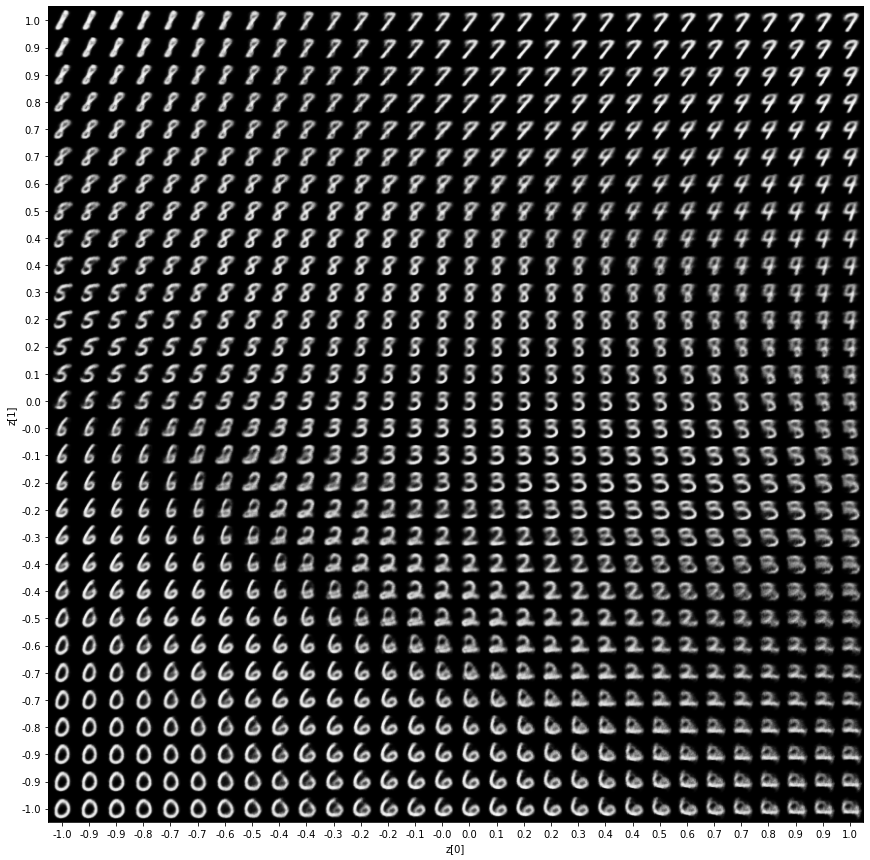

In [10]:
import matplotlib.pyplot as plt


def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)

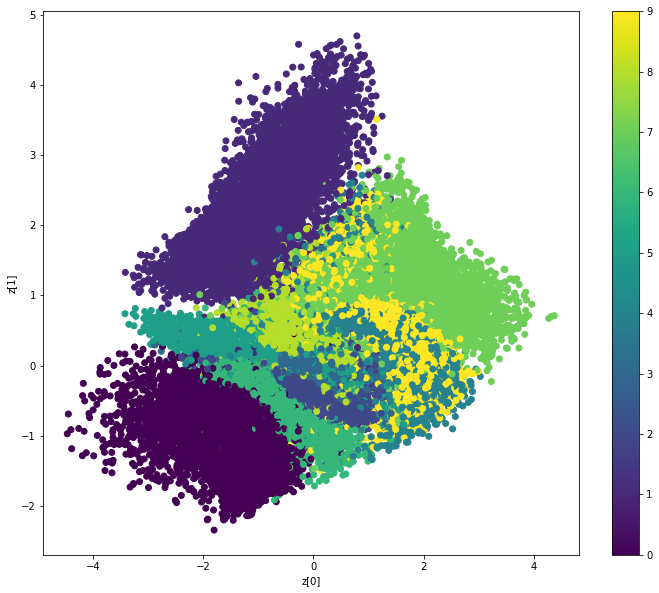

In [9]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)